In [1]:
import requests
import pandas as pd

In [2]:
base_url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-commune/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
response = requests.get(base_url)
response.raise_for_status()

In [3]:
filename = "georef-france-commune_all.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print(f"Downloaded {filename}")

Downloaded georef-france-commune_all.csv


In [4]:
data = pd.read_csv(
    filename,
    delimiter=";",
    usecols=[
        "Geo Point",
        "Nom Officiel Département",
        "Nom Officiel Commune",
        "Code Officiel Commune",
    ],
)

data.columns

Index(['Geo Point', 'Nom Officiel Département', 'Code Officiel Commune',
       'Nom Officiel Commune'],
      dtype='object')

In [5]:
data.filter(like="Code").head()

,Code Officiel Commune
0,19263
1,21032
2,21079
3,21110
4,21121


In [6]:
populations = pd.read_csv(
    "./base-pop-historiques2021.csv",
    sep=";",
)
populations["PMUN2021"] = populations["PMUN2021"].str.replace(" ", "").astype(int)

In [7]:
data_with_population = data.join(
    populations.set_index("CODGEO")[["PMUN2021"]], on="Code Officiel Commune"
)

population_paris = sum(
    populations.loc[populations["LIBGEO"].str.startswith("Paris "), "PMUN2021"]
)
data_with_population.loc[
    data_with_population["Nom Officiel Commune"] == "Paris", "PMUN2021"
] = population_paris

data_with_population.rename(columns={"PMUN2021": "population"}, inplace=True)


In [8]:
data_with_population[data_with_population["population"].isnull()]

,Geo Point,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population
915,"-12.924153939619153, 45.09853763215136",Mayotte,97604,Bouéni,NaN
1244,"18.07762061872796, -63.05507063109811",Saint-Martin,97801,Saint-Martin,NaN
3579,"46.95161199934115, -56.32441980597079",Saint-Pierre-et-Miquelon,97501,Miquelon-Langlade,NaN
4881,"49.33738546506057, 2.031190143757159",Oise,60694,Les Hauts-Talican,NaN
6236,"-12.778093677135729, 45.28230541512061",Mayotte,97608,Dzaoudzi,NaN
6237,"-37.99410414396906, 77.53477322150445",Terres australes et antarctiques françaises,98411,Îles Saint-Paul et Nouvelle-Amsterdam,NaN
6238,"-14.2704111989159, -178.15526303546318",Wallis et Futuna,98612,Sigave,NaN
7506,"-12.723470117447548, 45.11797122076654",Mayotte,97602,Bandraboua,NaN
8612,"-59.99589495050552, 138.99284362792966",Terres australes et antarctiques françaises,98414,La Terre-Adélie,NaN
9007,"-12.971818498653072, 45.126069810082015",Mayotte,97609,Kani-Kéli,NaN


In [9]:
# split Geo Point into latitude and longitude
data_with_population[["latitude", "longitude"]] = data_with_population[
    "Geo Point"
].str.split(",", expand=True)
data_with_population = data_with_population.drop(columns=["Geo Point"])
data_with_population["latitude"] = (
    data_with_population["latitude"].astype(float).round(2)
)
data_with_population["longitude"] = (
    data_with_population["longitude"].astype(float).round(2)
)
data_with_population

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
0,Corrèze,19263,Soudeilles,294.0,45.45,2.06
1,Côte-d'Or,21032,Aubigny-la-Ronce,167.0,46.99,4.60
2,Côte-d'Or,21079,Blagny-sur-Vingeanne,127.0,47.44,5.36
3,Côte-d'Or,21110,Brochon,657.0,47.24,4.96
4,Côte-d'Or,21121,Bussy-la-Pesle,76.0,47.36,4.71
...,...,...,...,...,...,...
34943,Charente,16184,Lichères,91.0,45.90,0.22
34944,Charente,16210,Marsac,790.0,45.74,0.08
34945,Charente,16271,Puymoyen,2388.0,45.62,0.17
34946,Charente,16337,Saint-Maurice-des-Lions,895.0,45.97,0.70


In [10]:
data_with_population.sort_values("population", ascending=False).head()

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
17344,Paris,75056,Paris,2133111.0,48.86,2.34
15263,Bouches-du-Rhône,13055,Marseille,873076.0,43.29,5.42
8180,Rhône,69123,Lyon,522250.0,45.75,4.84
7337,Haute-Garonne,31555,Toulouse,504078.0,43.60,1.43
32450,Alpes-Maritimes,06088,Nice,348085.0,43.71,7.24


In [11]:
data_with_population.query("`Nom Officiel Commune` == 'Craponne'")

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
8179,Rhône,69069,Craponne,11903.0,45.75,4.73


In [12]:
data_with_population.to_csv("georef-france-commune.csv", index=False)

# Reindex from grid points

In [13]:
from pollen_forecast.copernicus import PollenForcastCopernicusGeneric

In [14]:
my_pollen = PollenForcastCopernicusGeneric(
    north=51.70, south=41.87, east=8.74, west=-5.33, prefix="./france_territory/"
)
my_pollen.get_pollen_data()

2025-03-27 14:53:08,057 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-27 14:53:08,441 INFO Request ID is 6a03d8e2-0508-42c0-90dd-68677d40e449
2025-03-27 14:53:08,508 INFO status has been updated to accepted
2025-03-27 14:53:16,914 INFO status has been updated to running
2025-03-27 14:53:29,714 INFO status has been updated to successful


WindowsPath('france_territory/grass_pollen_2024-05-26_2024-05-26.nc')

In [15]:
import xarray as xr

data = xr.open_dataset(my_pollen.filename)
data.coords["longitude"] = (data.coords["longitude"] + 180) % 360 - 180
data_sorted = data.sortby("longitude")
data_sorted

C:\Users\antoi\AppData\Local\Temp\ipykernel_2568\92422657.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  data = xr.open_dataset(my_pollen.filename)


<xarray.Dataset> Size: 5MB
Dimensions:    (latitude: 98, level: 1, time: 96, longitude: 140)
Coordinates:
  * latitude   (latitude) float32 392B 51.65 51.55 51.45 ... 42.15 42.05 41.95
  * level      (level) float32 4B 0.0
  * time       (time) timedelta64[ns] 768B 00:00:00 01:00:00 ... 3 days 23:00:00
  * longitude  (longitude) float32 560B -5.25 -5.15 -5.05 ... 8.45 8.55 8.65
Data variables:
    gpg_conc   (time, level, latitude, longitude) float32 5MB ...
Attributes:
    title:        GRASSPOLLEN Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240526+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of GRASSPOLLEN concentration...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

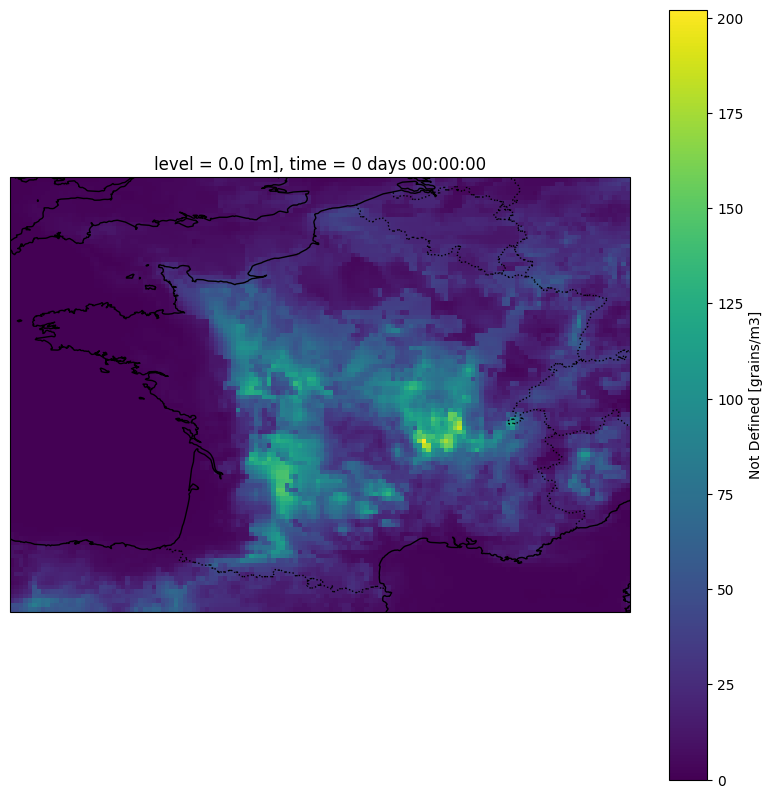

In [16]:
import cartopy
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
data_sorted["gpg_conc"].isel(time=0, level=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
)

ax.coastlines()
# add borders
ax.add_feature(cartopy.feature.BORDERS, linestyle=":")

In [17]:
communes = data_with_population  # pd.read_csv("georef-france-commune.csv")
communes.head()

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
0,Corrèze,19263,Soudeilles,294.0,45.45,2.06
1,Côte-d'Or,21032,Aubigny-la-Ronce,167.0,46.99,4.60
2,Côte-d'Or,21079,Blagny-sur-Vingeanne,127.0,47.44,5.36
3,Côte-d'Or,21110,Brochon,657.0,47.24,4.96
4,Côte-d'Or,21121,Bussy-la-Pesle,76.0,47.36,4.71


In [18]:
# find the neasrest grip point of the Xarray Dataset for each commune
def find_nearest_grip_point(lat, long, data):
    # print(f"Finding nearest grip point for {lat}, {long}")
    point = data.sel(latitude=lat, longitude=long, method="nearest")
    try:
        lat_nearest = point.latitude.values
        long_nearest = point.longitude.values
    except IndexError:
        print(f"Error with {lat}, {long}")
        print(point.latitude.values)
        print(point.longitude.values)
        return None, None

    return lat_nearest, long_nearest


communes["latitude"], communes["longitude"] = zip(
    *communes.apply(
        lambda x: find_nearest_grip_point(
            x["latitude"], x["longitude"], data_sorted
        ),
        axis=1,
    )
)
communes.head()

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
0,Corrèze,19263,Soudeilles,294.0,45.45,2.050003
1,Côte-d'Or,21032,Aubigny-la-Ronce,167.0,46.95,4.649994
2,Côte-d'Or,21079,Blagny-sur-Vingeanne,127.0,47.45,5.350006
3,Côte-d'Or,21110,Brochon,657.0,47.25,4.949997
4,Côte-d'Or,21121,Bussy-la-Pesle,76.0,47.35,4.75


In [19]:
communes.to_csv("georef-france-commune.csv", index=False)

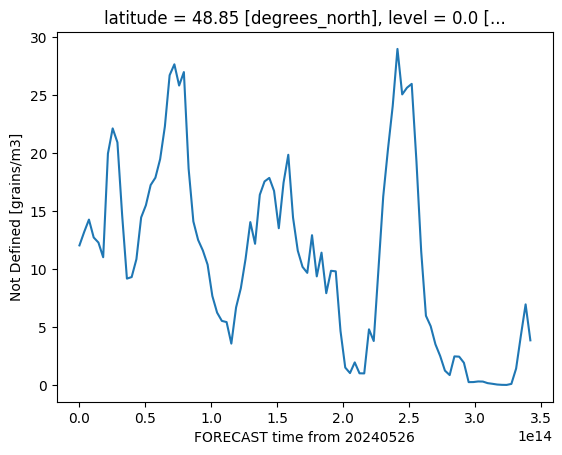

In [20]:
ax = (
    data_sorted["gpg_conc"]
    .sel(level=0, longitude=2.35, latitude=48.85, method="nearest")
    .plot()
)

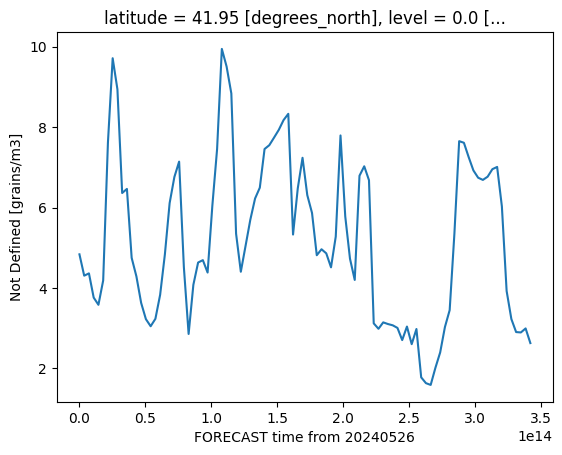

In [21]:
data_sorted["gpg_conc"].sel(
    level=0, latitude=4.85, longitude=45.75, method="nearest"
).plot()

# add Prefecture Label

In [22]:
from pathlib import Path
import pandas as pd

In [23]:

root_dir = Path("../data")
georef_filename = root_dir / "georef-france-commune.csv"
prefectures_filename =  root_dir / "prefectures.csv"

# georef_df = pd.read_csv(georef_filename)[["Nom Officiel Département", "Nom Officiel Commune", "latitude", "longitude"]]
# georef_df.head()

In [24]:
georef_df = communes
georef_df.head()

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude
0,Corrèze,19263,Soudeilles,294.0,45.45,2.050003
1,Côte-d'Or,21032,Aubigny-la-Ronce,167.0,46.95,4.649994
2,Côte-d'Or,21079,Blagny-sur-Vingeanne,127.0,47.45,5.350006
3,Côte-d'Or,21110,Brochon,657.0,47.25,4.949997
4,Côte-d'Or,21121,Bussy-la-Pesle,76.0,47.35,4.75


In [25]:
prefectures_df = pd.read_csv(prefectures_filename, sep=";")
prefectures_df.head()

,Geo Point,Geo Shape,gid,Code INSEE,Commune,Service
0,"44.38771428187486, 6.643645611399548","{""coordinates"": [6.643645611399548, 44.3877142...",13,04019,Barcelonnette,Sous-préfecture
1,"49.845842844647706, 3.290619591335112","{""coordinates"": [3.290619591335112, 49.8458428...",7,02691,Saint-Quentin,Sous-préfecture
2,"44.894321981740646, 6.632905771977145","{""coordinates"": [6.632905771977145, 44.8943219...",17,05023,Briançon,Sous-préfecture
3,"45.75813629221574, 5.686648106090643","{""coordinates"": [5.686648106090643, 45.7581362...",1,01034,Belley,Sous-préfecture
4,"48.585217460500026, 7.736631137529066","{""coordinates"": [7.736631137529066, 48.5852174...",239,67482,Strasbourg,Préfecture de région


In [26]:
prefectures_df["Service"].unique()

array(['Sous-préfecture', 'Préfecture de région', 'Préfecture',
       'Capitale'], dtype=object)

In [27]:
georef_df["is_prefecture"] = False
georef_df["is_sous_prefecture"] = False
for name in prefectures_df["Commune"]:
    is_sous_prefecture = (prefectures_df.loc[prefectures_df["Commune"]==name, "Service"] == "Sous-préfecture").all()
    mask = georef_df["Nom Officiel Commune"].str.lower() == name.lower()
    
    if sum(mask) == 1:
        if is_sous_prefecture:
            georef_df.loc[mask, "is_sous_prefecture"] = True
        else:
            georef_df.loc[mask, "is_prefecture"] = True

    elif sum(mask) > 1:
        lat, lon = prefectures_df.loc[prefectures_df["Commune"] == name, "Geo Point"].item().split(",")
        lat, lon = float(lat), float(lon)
        min_distance = 999999999
        for idx, row in georef_df[mask].iterrows():
            distance = ( (row["latitude"] - lat) ** 2 + (row["longitude"] - lon) ** 2 ) ** 0.5
            if distance < min_distance:
                min_idx = idx
                min_name = row["Nom Officiel Commune"]
                min_distance = distance
        if is_sous_prefecture:
            georef_df.loc[min_idx, "is_sous_prefecture"] = True
        else:
            georef_df.loc[min_idx, "is_prefecture"] = True
    else:
        print("no match", name, prefectures_df.loc[prefectures_df["Commune"]==name, "Service"])
        

In [28]:
georef_df.to_csv(georef_filename)

In [29]:
georef_df

,Nom Officiel Département,Code Officiel Commune,Nom Officiel Commune,population,latitude,longitude,is_prefecture,is_sous_prefecture
0,Corrèze,19263,Soudeilles,294.0,45.45,2.050003,False,False
1,Côte-d'Or,21032,Aubigny-la-Ronce,167.0,46.95,4.649994,False,False
2,Côte-d'Or,21079,Blagny-sur-Vingeanne,127.0,47.45,5.350006,False,False
3,Côte-d'Or,21110,Brochon,657.0,47.25,4.949997,False,False
4,Côte-d'Or,21121,Bussy-la-Pesle,76.0,47.35,4.75,False,False
...,...,...,...,...,...,...,...,...
34943,Charente,16184,Lichères,91.0,45.95,0.25,False,False
34944,Charente,16210,Marsac,790.0,45.75,0.05000305,False,False
34945,Charente,16271,Puymoyen,2388.0,45.65,0.1499939,False,False
34946,Charente,16337,Saint-Maurice-des-Lions,895.0,45.95,0.75,False,False
